# Variational Bayes under model misspecification

Jacqueline R. M. A. Maasch | April 2023 Year

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import time
from scipy import stats
import warnings

# Stan-related importations.
import stan
import arviz as az # For visualization and loo.
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.2
numpy version      : 1.22.2
pandas version     : 1.4.1
matplotlib version : 3.5.1
seaborn version    : 0.12.2


## Define functions

## Generate data from a mixture of Gaussians

Under the true generating process, data are sampled from a mixture of two Gaussians with equal variance.

In [2]:
# Total samples.
n = 5000

# Gaussian component means vary but standard deviations are equal.
#mu = np.random.uniform(1, 10, 2)
#sigma = np.random.uniform(1, 5, 1)
mu = np.array([1.25, 4.75])
sigma = np.array([1.5])

# Mixture membership is the result of a Bernoulli trial.
p = 0.5
mixture_id = stats.bernoulli.rvs(p, size = n)

# Each observation is drawn from the normal to which it was assigned.
# Note that scale = sd, not var.
y_true = stats.norm.rvs(loc = mu[mixture_id], scale = sigma, size = n)
df = pd.DataFrame({"Component ID": mixture_id, 
                   "Ground truth": y_true})
df["Component mean"] = df["Component ID"].map(lambda x: mu[x])

In [3]:
# Examine distributions.
print("-*- Component 0 -*-")
print("Ground truth mean :", mu[0])
print("Sample mean       :", df[df["Component ID"] == 0]["Ground truth"].mean())
print("Ground truth SD   :", *sigma)
print("Sample SD         :", df[df["Component ID"] == 0]["Ground truth"].std())

print("\n-*- Component 1 -*-")
print("Ground truth mean :", mu[1])
print("Sample mean       :", df[df["Component ID"] == 1]["Ground truth"].mean())
print("Ground truth SD   :", *sigma)
print("Sample SD         :", df[df["Component ID"] == 1]["Ground truth"].std(), "\n")

display(df)

-*- Component 0 -*-
Ground truth mean : 1.25
Sample mean       : 1.2708206308788774
Ground truth SD   : 1.5
Sample SD         : 1.5513491949792464

-*- Component 1 -*-
Ground truth mean : 4.75
Sample mean       : 4.7573940572013065
Ground truth SD   : 1.5
Sample SD         : 1.4878484152724918 



,Component ID,Ground truth,Component mean
0,0,2.289032,1.25
1,0,1.845212,1.25
2,1,5.819472,4.75
3,1,2.348671,4.75
4,1,4.622207,4.75
...,...,...,...
4995,1,5.535280,4.75
4996,1,2.781179,4.75
4997,1,6.814166,4.75
4998,1,6.190479,4.75


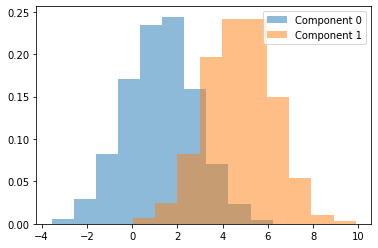

In [4]:
plt.hist(df[df["Component ID"] == 0]["Ground truth"], alpha = 0.5, label = "Component 0", density = True)
plt.hist(df[df["Component ID"] == 1]["Ground truth"], alpha = 0.5, label = "Component 1", density = True)
plt.legend(loc = "upper right")
plt.show()

## Stan model configurations

In [5]:
# Place data in dictionary for Stan models.
stan_data = {"N": df.shape[0], 
             "y": df["Ground truth"].values}

# Filter warnings?
warnings_setting = "ignore" # "once"

# Sampling parameters.
n_fit = 1000
n_warmup = 250
n_chains = 2

## Correctly specified mixture model

### Define model

In [41]:
stan_folder = "./"
stan_file = stan_folder + "mixture_model_correctly_specified.stan"
with open(stan_file) as file:
    correct_model = file.read()
print(correct_model)

/*
# MIXTURE MODELS
https://betanalpha.github.io/assets/case_studies/mixture_models.html
https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html
https://github.com/nikhgarg/2023_ADBA_PhDclass/blob/main/lecture7_mixtureofnormals.ipynb
https://mc-stan.org/docs/stan-users-guide/summing-out-the-responsibility-parameter.html

# VI
https://mc-stan.org/docs/cmdstan-guide/variational-inference.html
https://mc-stan.org/docs/cmdstan-guide/variational-inference-algorithm-advi.html
https://cmdstanpy.readthedocs.io/en/v0.9.77/examples/Variational%20Inference.html
https://cmdstanpy.readthedocs.io/en/stable-0.9.65/variational_bayes.html

# MCMC
https://mc-stan.org/docs/cmdstan-guide/mcmc-config.html
https://mc-stan.org/docs/cmdstan-guide/mcmc-intro.html

# DISTRIBUTIONS
https://mc-stan.org/docs/2_18/functions-reference/student-t-distribution.html
*/
data {
    int<lower=0> N;
    vector[N] y;
}

parameters {
    vector[2] mu;
    real<lower=0> sigma;
    real<lower=0,uppe

### Compile

In [42]:
# Compile model.
warnings.filterwarnings(warnings_setting)
correct_model_compiled = stan.build(correct_model, data = stan_data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/vh/cf7rsl714n962tdqmvnhfmvh0000gp/T/httpstan_ffay1q5z/model_2wssbntp.stan', line 39, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.


### Fit

In [43]:
# Fit correct model.
correct_model_fit = correct_model_compiled.sample(num_chains = n_chains, 
                                                  num_warmup = n_warmup, 
                                                  num_samples = n_fit)

Sampling:   0%
Sampling:   0% (1/2500)
Sampling:   0% (2/2500)
Sampling:   4% (101/2500)
Sampling:   8% (201/2500)
Sampling:  10% (252/2500)
Sampling:  14% (351/2500)
Sampling:  18% (451/2500)
Sampling:  22% (551/2500)
Sampling:  26% (651/2500)
Sampling:  30% (751/2500)
Sampling:  34% (851/2500)
Sampling:  38% (950/2500)
Sampling:  42% (1050/2500)
Sampling:  46% (1150/2500)
Sampling:  48% (1201/2500)
Sampling:  52% (1301/2500)
Sampling:  56% (1400/2500)
Sampling:  60% (1500/2500)
Sampling:  64% (1600/2500)
Sampling:  68% (1700/2500)
Sampling:  72% (1800/2500)
Sampling:  76% (1900/2500)
Sampling:  80% (2000/2500)
Sampling:  84% (2100/2500)
Sampling:  88% (2200/2500)
Sampling:  92% (2300/2500)
Sampling:  96% (2400/2500)
Sampling: 100% (2500/2500)
Sampling: 100% (2500/2500), done.
Messages received during sampling:
  Gradient evaluation took 0.001287 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.87 seconds.
  Adjust your expectations accordingly!
  Gradie

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],4.677,0.049,4.584,4.766,0.002,0.001,811.0,1145.0,1.0
mu[1],1.194,0.053,1.101,1.295,0.002,0.001,1105.0,1224.0,1.0
sigma,1.523,0.025,1.478,1.570,0.001,0.000,1745.0,1429.0,1.0
theta,0.516,0.013,0.491,0.538,0.000,0.000,819.0,1066.0,1.0
y_posterior_pred[0],2.493,2.222,-1.448,6.403,0.049,0.035,2077.0,2048.0,1.0
...,...,...,...,...,...,...,...,...,...
component_id_pred[4995],0.620,0.486,0.000,1.000,0.011,0.008,1834.0,1834.0,1.0
component_id_pred[4996],0.630,0.483,0.000,1.000,0.011,0.008,2050.0,2000.0,1.0
component_id_pred[4997],0.642,0.480,0.000,1.000,0.011,0.008,1874.0,1874.0,1.0
component_id_pred[4998],0.622,0.485,0.000,1.000,0.011,0.008,1830.0,1830.0,1.0


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n0'}>],
       [<AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n0'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n0'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n1'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n1'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n2'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n2'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n3'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n3'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n4'}>,
        <AxesSubplot:title={'center':'y_posterior_

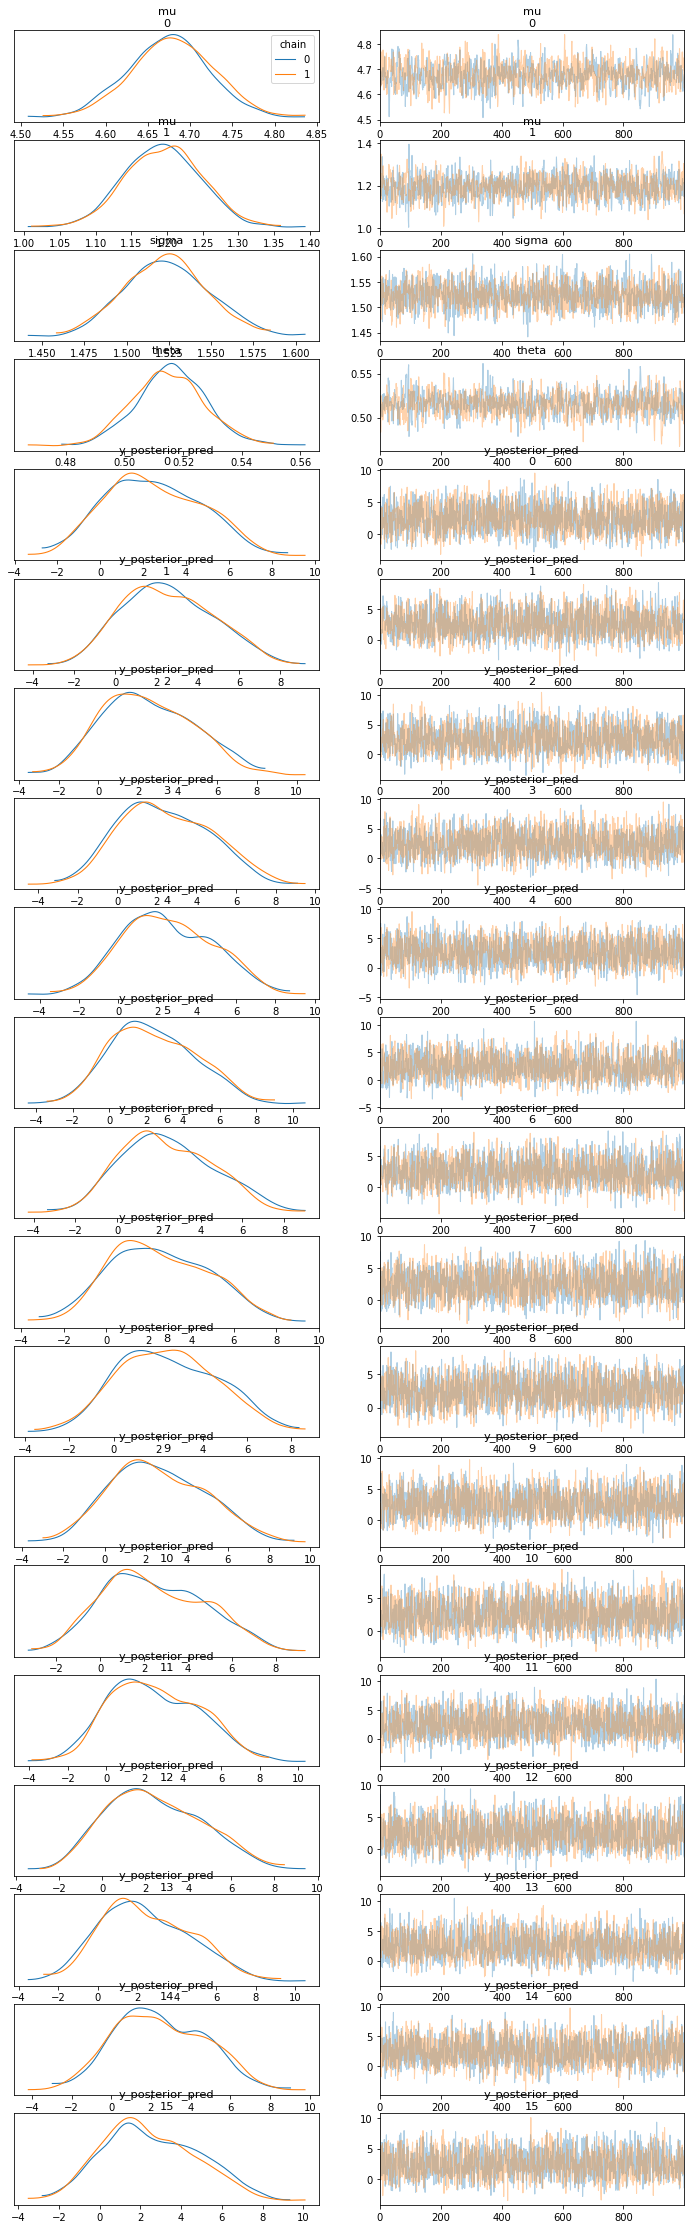

In [44]:
# View correct model summary.
correct_model_summary = az.summary(correct_model_fit)
display(correct_model_summary)
az.plot_trace(correct_model_fit, compact = False, legend = True)

array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n0'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n1'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n2'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n3'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n4'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n5'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n6'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n7'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n8'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n9'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n10'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n11'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n12

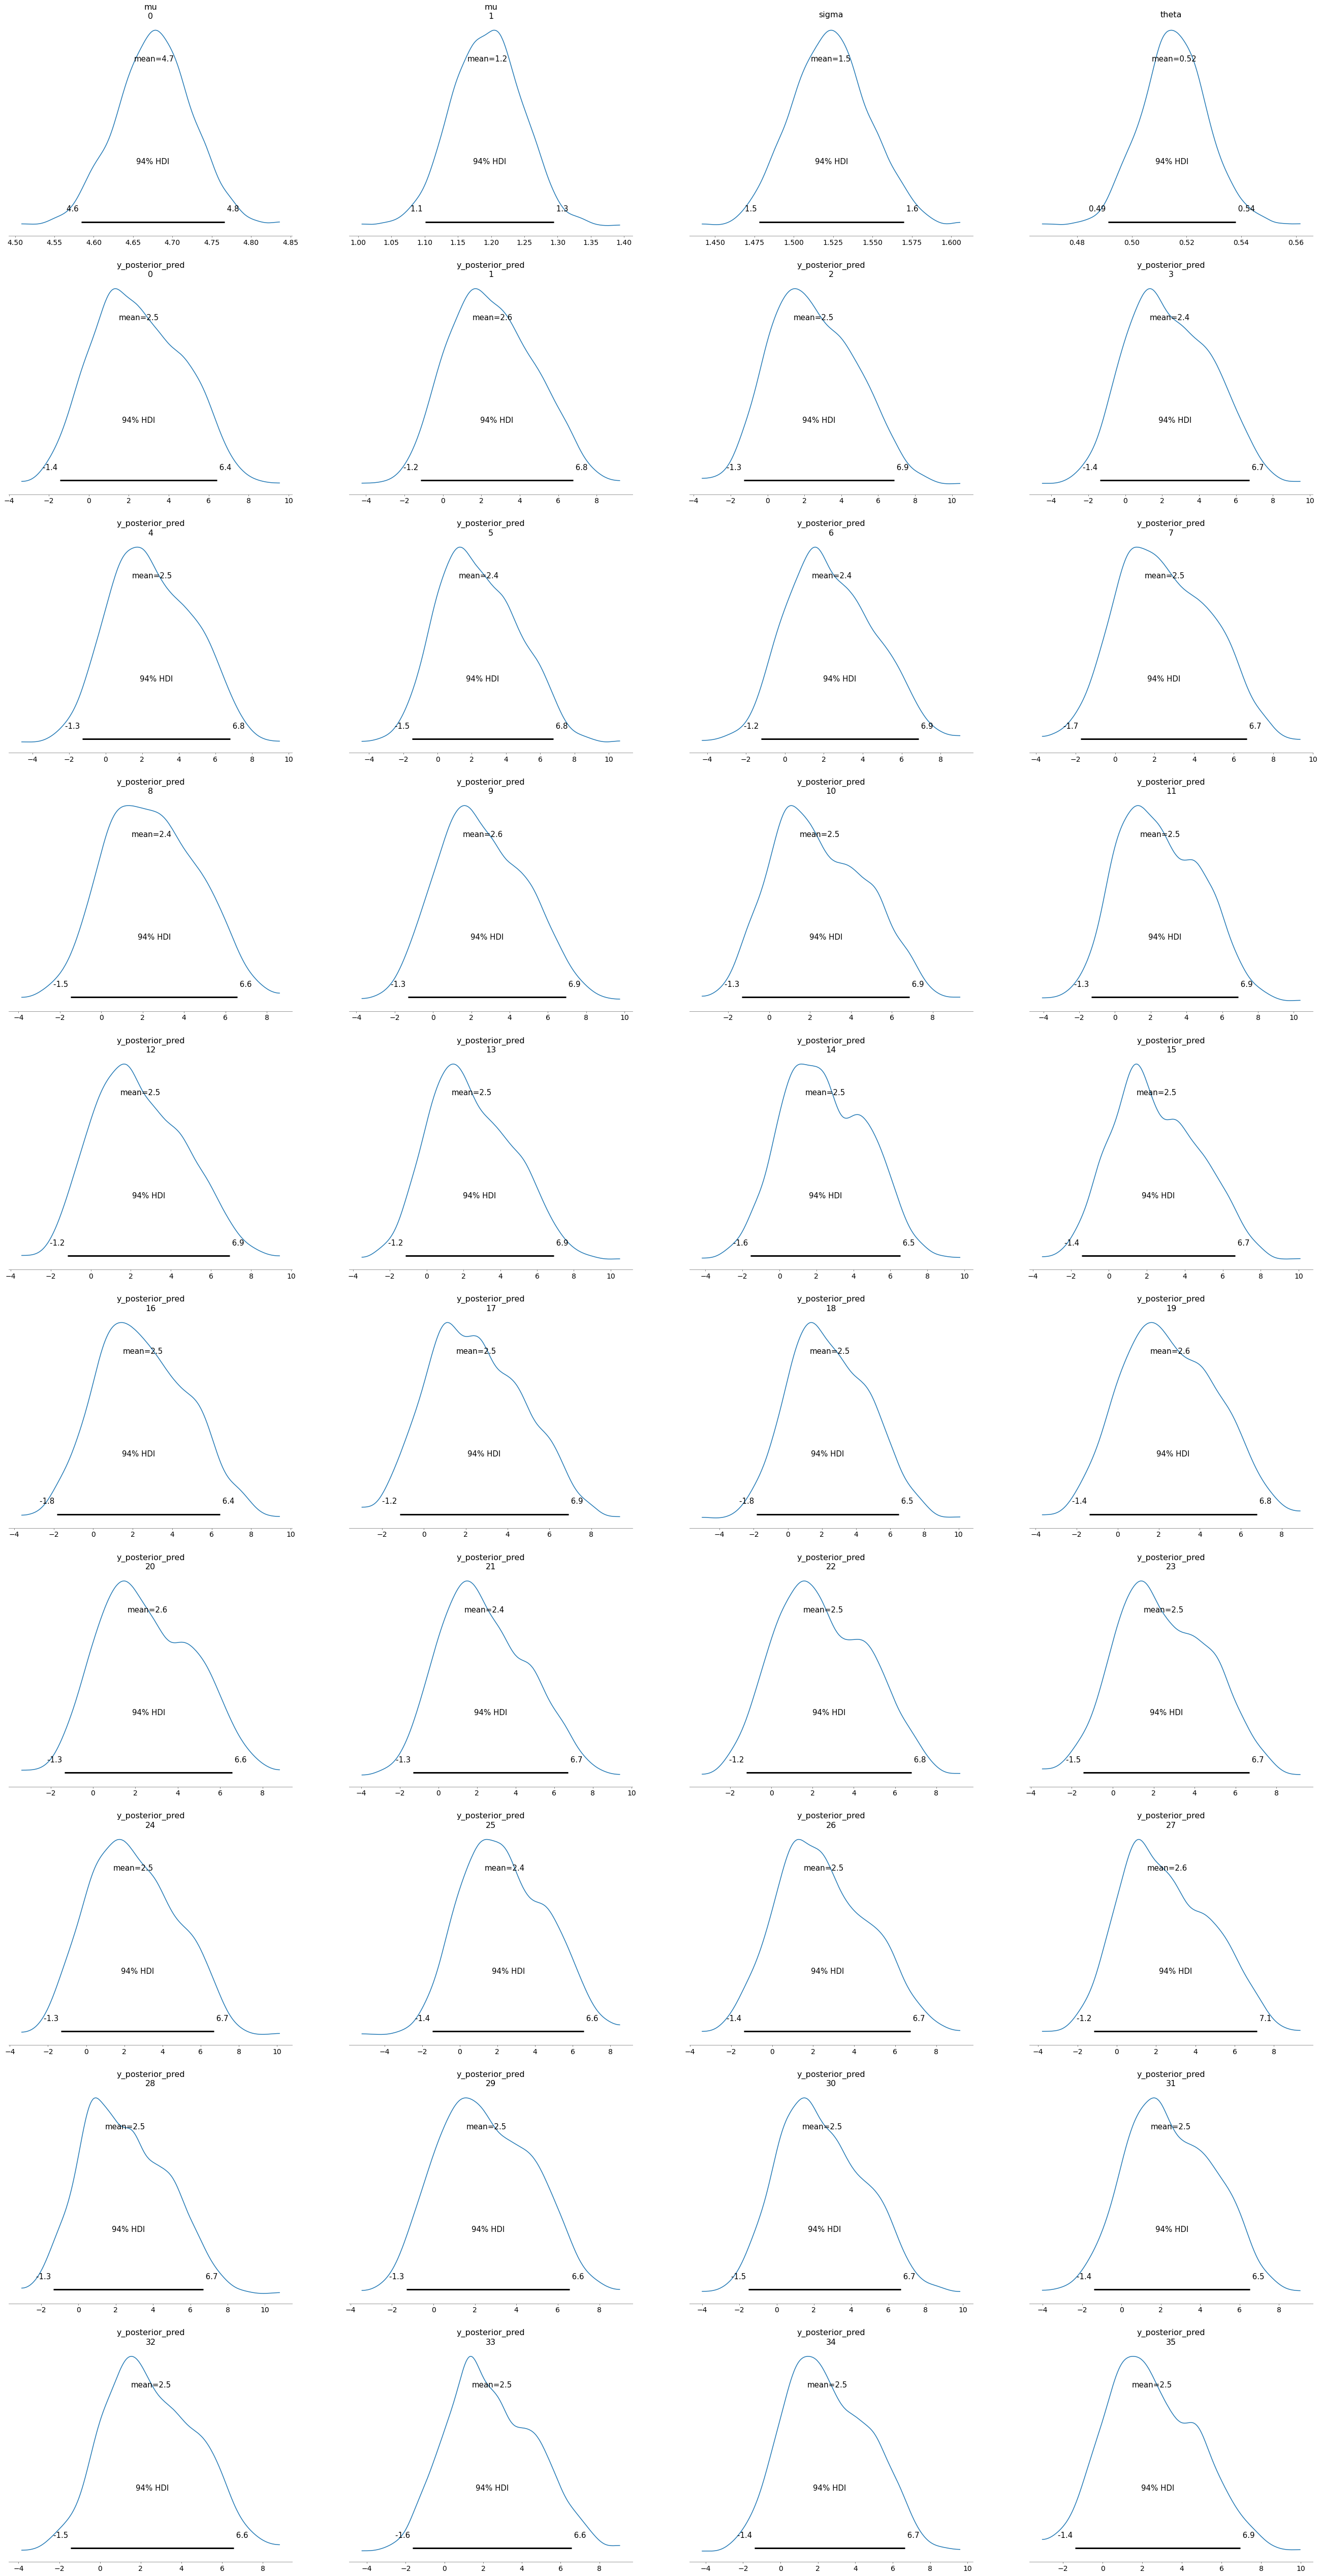

In [45]:
# Plot correct model posterior.
correct_model_idata = az.from_pystan(posterior = correct_model_fit, 
                                     posterior_model = correct_model_compiled)
az.plot_posterior(correct_model_idata)

### Posterior predictive check

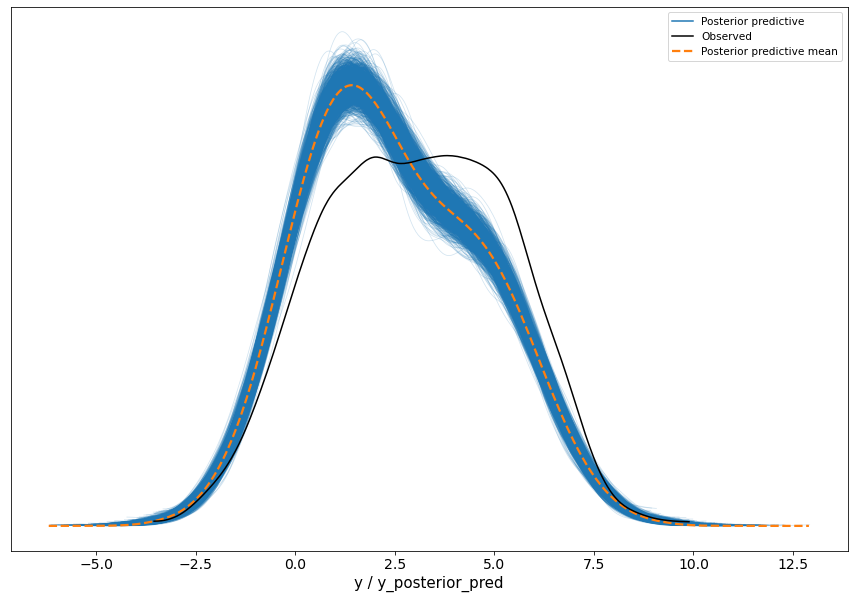

In [46]:
plt.rcParams["figure.figsize"] = (15, 10)
correct_model_ppc_data = az.from_pystan(posterior = correct_model_fit,
                                        posterior_model = correct_model_compiled,
                                        posterior_predictive = ["y_posterior_pred"], 
                                        observed_data = ["y"])
ax = az.plot_ppc(data = correct_model_ppc_data, 
                 data_pairs = {"y": "y_posterior_pred"})
plt.show()
plt.close()

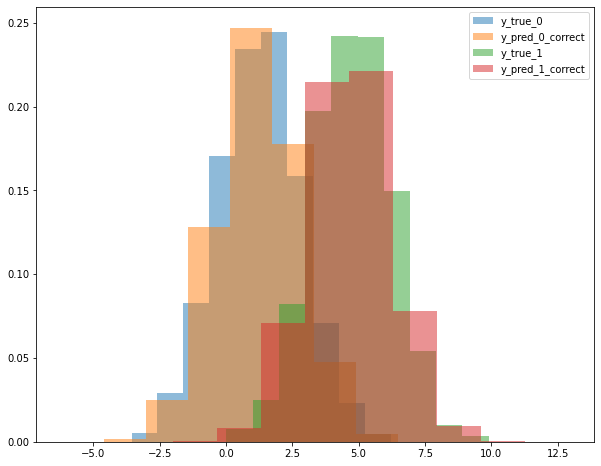

In [48]:
# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_correct = correct_model_idata.posterior.component_id_pred.values.flatten()

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_correct = correct_model_idata.posterior.y_posterior_pred.values
y_pred_correct = y_pred_correct.flatten()
y_pred_0_correct = y_pred_correct[component_pred_correct.astype(bool)]
y_pred_1_correct = y_pred_correct[~component_pred_correct.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_correct, alpha = 0.5, label = "y_pred_0_correct", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_correct, alpha = 0.5, label = "y_pred_1_correct", density = True)
plt.legend(loc = "upper right")
plt.show()

In [36]:
np.unique(component_pred_correct, return_counts = True)

(array([0, 1]), array([3738268, 6261732]))

In [13]:
# Compare predicted component standard deviations to ground truth.
round_by = 3
sigma_pred_mean_correct = correct_model_idata.posterior.sigma.values.flatten().mean()
sigma_pred_sd_correct = correct_model_idata.posterior.sigma.values.flatten().std()
print("True standard deviation      :", *sigma)
print("Predicted standard deviation : {} (SD = {})".format(round(sigma_pred_mean_correct, round_by), 
                                                           round(sigma_pred_sd_correct, round_by)))

True standard deviation      : 1.5
Predicted standard deviation : 1.523 (SD = 0.025)


In [32]:
# Compare predicted component means to ground truth.
mu_0_pred_correct = [i[:,0] for i in correct_model_idata.posterior.mu.values]
mu_0_pred_correct = np.array(mu_0_pred_correct).flatten()
mu_1_pred_correct = [i[:,1] for i in correct_model_idata.posterior.mu.values]
mu_1_pred_correct = np.array(mu_1_pred_correct).flatten()

round_by = 3
print("-*- Component 0 -*-")
print("True mean      :", mu[0])
print("Predicted mean : {} (SD = {})".format(round(mu_0_pred_correct.mean(), round_by), 
                                             round(mu_0_pred_correct.std(), round_by)))
print("\n-*- Component 1 -*-")
print("True mean      :", mu[1])
print("Predicted mean : {} (SD = {})".format(round(mu_1_pred_correct.mean(), round_by), 
                                             round(mu_1_pred_correct.std(), round_by)))

-*- Component 0 -*-
True mean      : 1.25
Predicted mean : 4.677 (SD = 0.049)

-*- Component 1 -*-
True mean      : 4.75
Predicted mean : 1.194 (SD = 0.053)


## Misspecified mixture model

### Define model

In [15]:
stan_folder = "./"
stan_file = stan_folder + "mixture_model_misspecified.stan"
with open(stan_file) as file:
    misspecified_model = file.read()
print(misspecified_model)

/*
# MIXTURE MODELS
https://betanalpha.github.io/assets/case_studies/mixture_models.html
https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html
https://github.com/nikhgarg/2023_ADBA_PhDclass/blob/main/lecture7_mixtureofnormals.ipynb
https://mc-stan.org/docs/stan-users-guide/summing-out-the-responsibility-parameter.html

# VI
https://mc-stan.org/docs/cmdstan-guide/variational-inference.html
https://mc-stan.org/docs/cmdstan-guide/variational-inference-algorithm-advi.html
https://cmdstanpy.readthedocs.io/en/v0.9.77/examples/Variational%20Inference.html
https://cmdstanpy.readthedocs.io/en/stable-0.9.65/variational_bayes.html

# MCMC
https://mc-stan.org/docs/cmdstan-guide/mcmc-config.html
https://mc-stan.org/docs/cmdstan-guide/mcmc-intro.html

# DISTRIBUTIONS
https://mc-stan.org/docs/2_18/functions-reference/student-t-distribution.html
*/
data {
    int<lower=0> N;
    vector[N] y;
}

/*
Mixture model parameters when components are t-distributions:
- mu: locati

### Compile

In [16]:
# Compile model.
warnings.filterwarnings(warnings_setting)
misspecified_model_compiled = stan.build(misspecified_model, data = stan_data)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In 

Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused vari

Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.8s
Building: 9.9s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/L

Building: 10.0s
Building: 10.1s
Building: 10.2s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_

Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In 

Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.8s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7

Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                             

Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s


11 warnings generated.


Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.2s
Building: 24.3s
Building: 24.4s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In 

Building: 25.5s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.4s
Building: 26.5s
Building: 26.6s
Building: 26.7s
Building: 26.8s
Building: 26.9s
Building: 27.0s
Building: 27.1s
Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s
Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.5s
Building: 29.6s
Building: 29.7s
Building: 29.8s
Building: 29.9s
Building: 30.0s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused vari

Building: 30.1s
Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.5s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/L

Building: 30.6s
Building: 30.7s
Building: 30.8s
Building: 30.9s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_

Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.4s
Building: 31.5s
Building: 31.7s
Building: 31.8s
Building: 31.9s
Building: 32.0s
Building: 32.1s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.5s
Building: 32.6s
Building: 32.7s
Building: 32.8s
Building: 32.9s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In 

Building: 33.0s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.5s
Building: 33.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7

Building: 33.7s
Building: 33.8s
Building: 33.9s
Building: 34.0s
Building: 34.1s
Building: 34.2s
Building: 34.3s
Building: 34.4s
Building: 34.6s
Building: 34.7s
Building: 34.8s
Building: 34.9s


In file included from /Users/jacquelinemaasch/Library/Caches/httpstan/4.9.1/models/bvezs7at/model_bvezs7at.cpp:2:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                             

Building: 35.0s
Building: 35.1s
Building: 35.2s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.7s
Building: 35.8s
Building: 35.9s
Building: 36.0s
Building: 36.1s
Building: 36.2s
Building: 36.3s
Building: 36.4s
Building: 36.5s
Building: 36.6s
Building: 36.7s
Building: 36.8s
Building: 36.9s
Building: 37.0s
Building: 37.1s
Building: 37.2s
Building: 37.3s
Building: 37.4s
Building: 37.5s
Building: 37.7s
Building: 37.8s
Building: 37.9s
Building: 38.0s
Building: 38.1s
Building: 38.2s
Building: 38.3s
Building: 38.4s
Building: 38.5s
Building: 38.6s
Building: 38.7s
Building: 38.8s
Building: 38.9s
Building: 39.0s
Building: 39.1s
Building: 39.2s
Building: 39.3s
Building: 39.4s
Building: 39.5s
Building: 39.6s
Building: 39.7s
Building: 39.8s
Building: 39.9s
Building: 40.0s
Building: 40.1s
Building: 40.2s
Building: 40.3s
Building: 40.4s
Building: 40.6s
Building: 40.7s
Building: 40.8s
Building: 40.9s
Building: 41.0s
Building: 41.1s
Building: 41.2s
Building: 41.3s
Building

11 warnings generated.


Building: 42.4s
Building: 42.5s


ld: warning: ignoring file /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/stan_services.o, building for macOS-arm64 but attempting to link with file built for unknown-x86_64
ld: warning: ignoring file /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/lib/libsundials_cvodes.a, building for macOS-arm64 but attempting to link with file built for macOS-x86_64
ld: warning: ignoring file /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a, building for macOS-arm64 but attempting to link with file built for macOS-x86_64
ld: warning: ignoring file /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/lib/libtbb.dylib, building for macOS-arm64 but attempting to link with file built for macOS-x86_64
ld: warning: ignoring file /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/httpstan/lib/libtb

### Fit

In [17]:
# Fit misspecified model.
warnings.filterwarnings(warnings_setting)
misspecified_model_fit = misspecified_model_compiled.sample(num_chains = n_chains, 
                                                            num_warmup = n_warmup, 
                                                            num_samples = n_fit)

Sampling:   0%
Sampling:   0% (1/2500)
Sampling:   0% (2/2500)
Sampling:   4% (101/2500)
Sampling:   8% (200/2500)
Sampling:  12% (300/2500)
Sampling:  16% (400/2500)
Sampling:  18% (451/2500)
Sampling:  20% (502/2500)
Sampling:  24% (601/2500)
Sampling:  28% (700/2500)
Sampling:  32% (800/2500)
Sampling:  36% (900/2500)
Sampling:  40% (1000/2500)
Sampling:  44% (1100/2500)
Sampling:  48% (1200/2500)
Sampling:  52% (1300/2500)
Sampling:  56% (1400/2500)
Sampling:  60% (1500/2500)
Sampling:  64% (1600/2500)
Sampling:  68% (1700/2500)
Sampling:  72% (1800/2500)
Sampling:  76% (1900/2500)
Sampling:  80% (2000/2500)
Sampling:  84% (2100/2500)
Sampling:  88% (2200/2500)
Sampling:  92% (2300/2500)
Sampling:  96% (2400/2500)
Sampling: 100% (2500/2500)
Sampling: 100% (2500/2500), done.
Messages received during sampling:
  Gradient evaluation took 0.002486 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.86 seconds.
  Adjust your expectations accordingly!
  Inform

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],1.198,0.050,1.103,1.294,0.001,0.001,1180.0,1631.0,1.0
mu[1],4.677,0.050,4.589,4.770,0.001,0.001,1227.0,1473.0,1.0
nu,61.478,32.100,22.171,120.983,0.864,0.624,1758.0,1197.0,1.0
sigma,1.498,0.026,1.448,1.548,0.001,0.000,1763.0,1276.0,1.0
theta,0.485,0.013,0.463,0.510,0.000,0.000,1090.0,1136.0,1.0
...,...,...,...,...,...,...,...,...,...
component_id_pred[4995],0.624,0.485,0.000,1.000,0.011,0.008,2069.0,2000.0,1.0
component_id_pred[4996],0.611,0.488,0.000,1.000,0.011,0.008,2044.0,2000.0,1.0
component_id_pred[4997],0.616,0.486,0.000,1.000,0.011,0.008,1913.0,1913.0,1.0
component_id_pred[4998],0.609,0.488,0.000,1.000,0.011,0.008,1975.0,1975.0,1.0


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n0'}>],
       [<AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n1'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n0'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n0'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n1'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n1'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n2'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n2'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n3'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n3'}>],
       [<AxesSubplot:

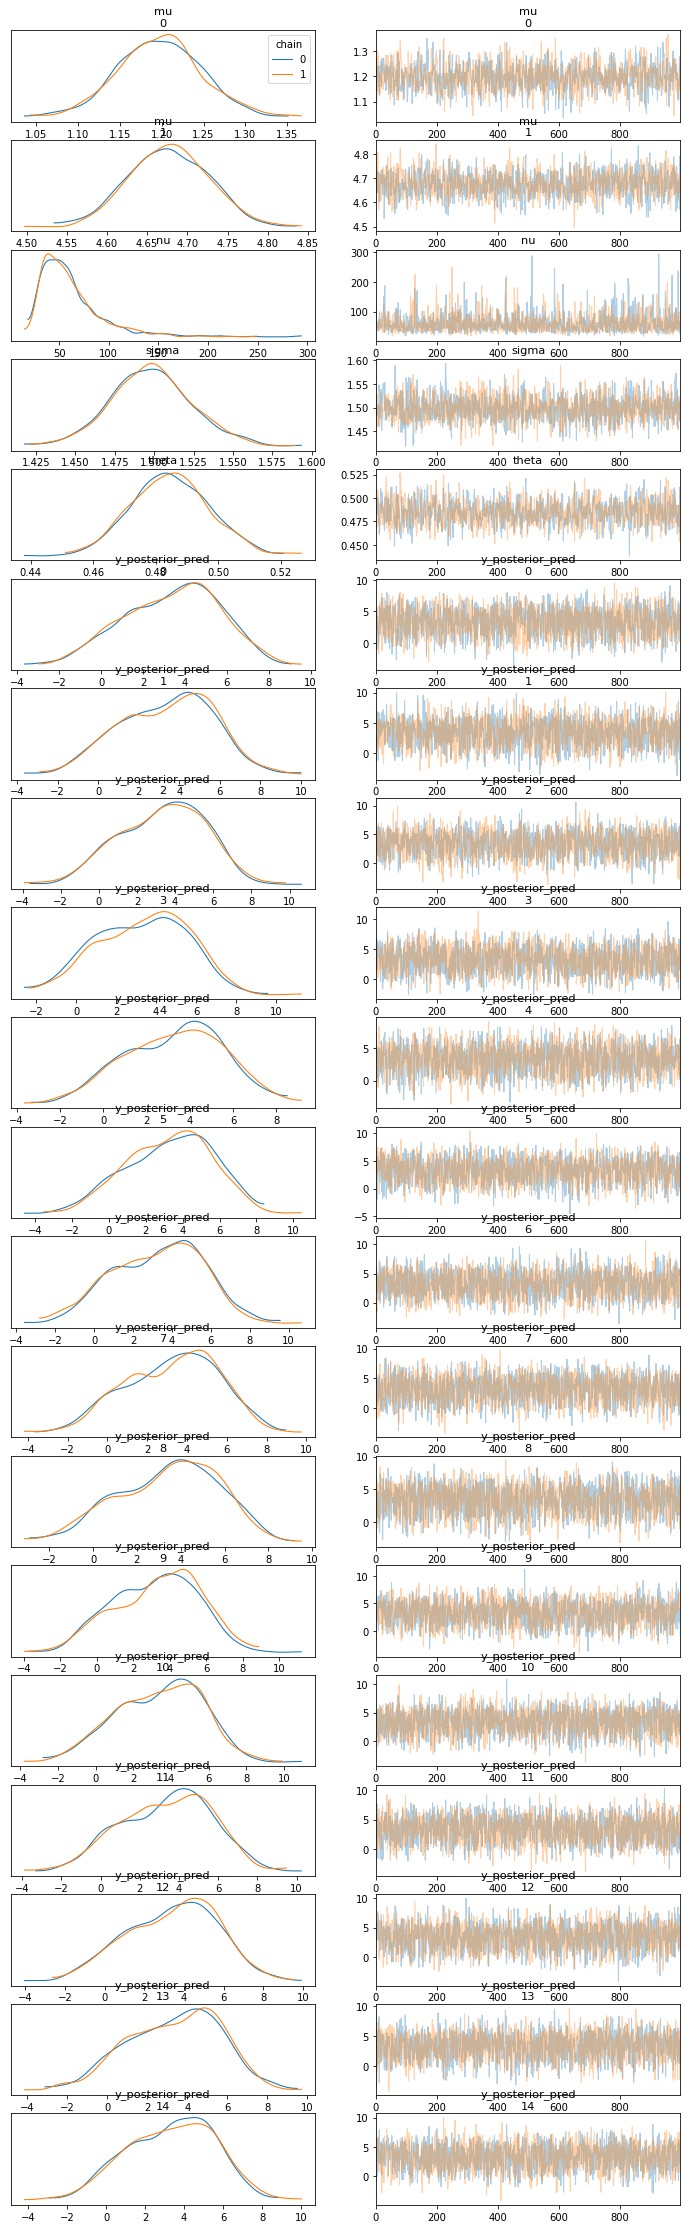

In [18]:
# View misspecified model summary.
misspecified_model_summary = az.summary(misspecified_model_fit)
display(misspecified_model_summary)
az.plot_trace(misspecified_model_fit, compact = False, legend = True)

array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n0'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n1'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n2'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n3'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n4'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n5'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n6'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n7'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n8'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n9'}>,
        <AxesSubplot:title={'center':'y_posterior_pred\n10'}>],
       [<AxesSubplot:title={'center':'y_posterior_pred\n11'}>,
        <Axes

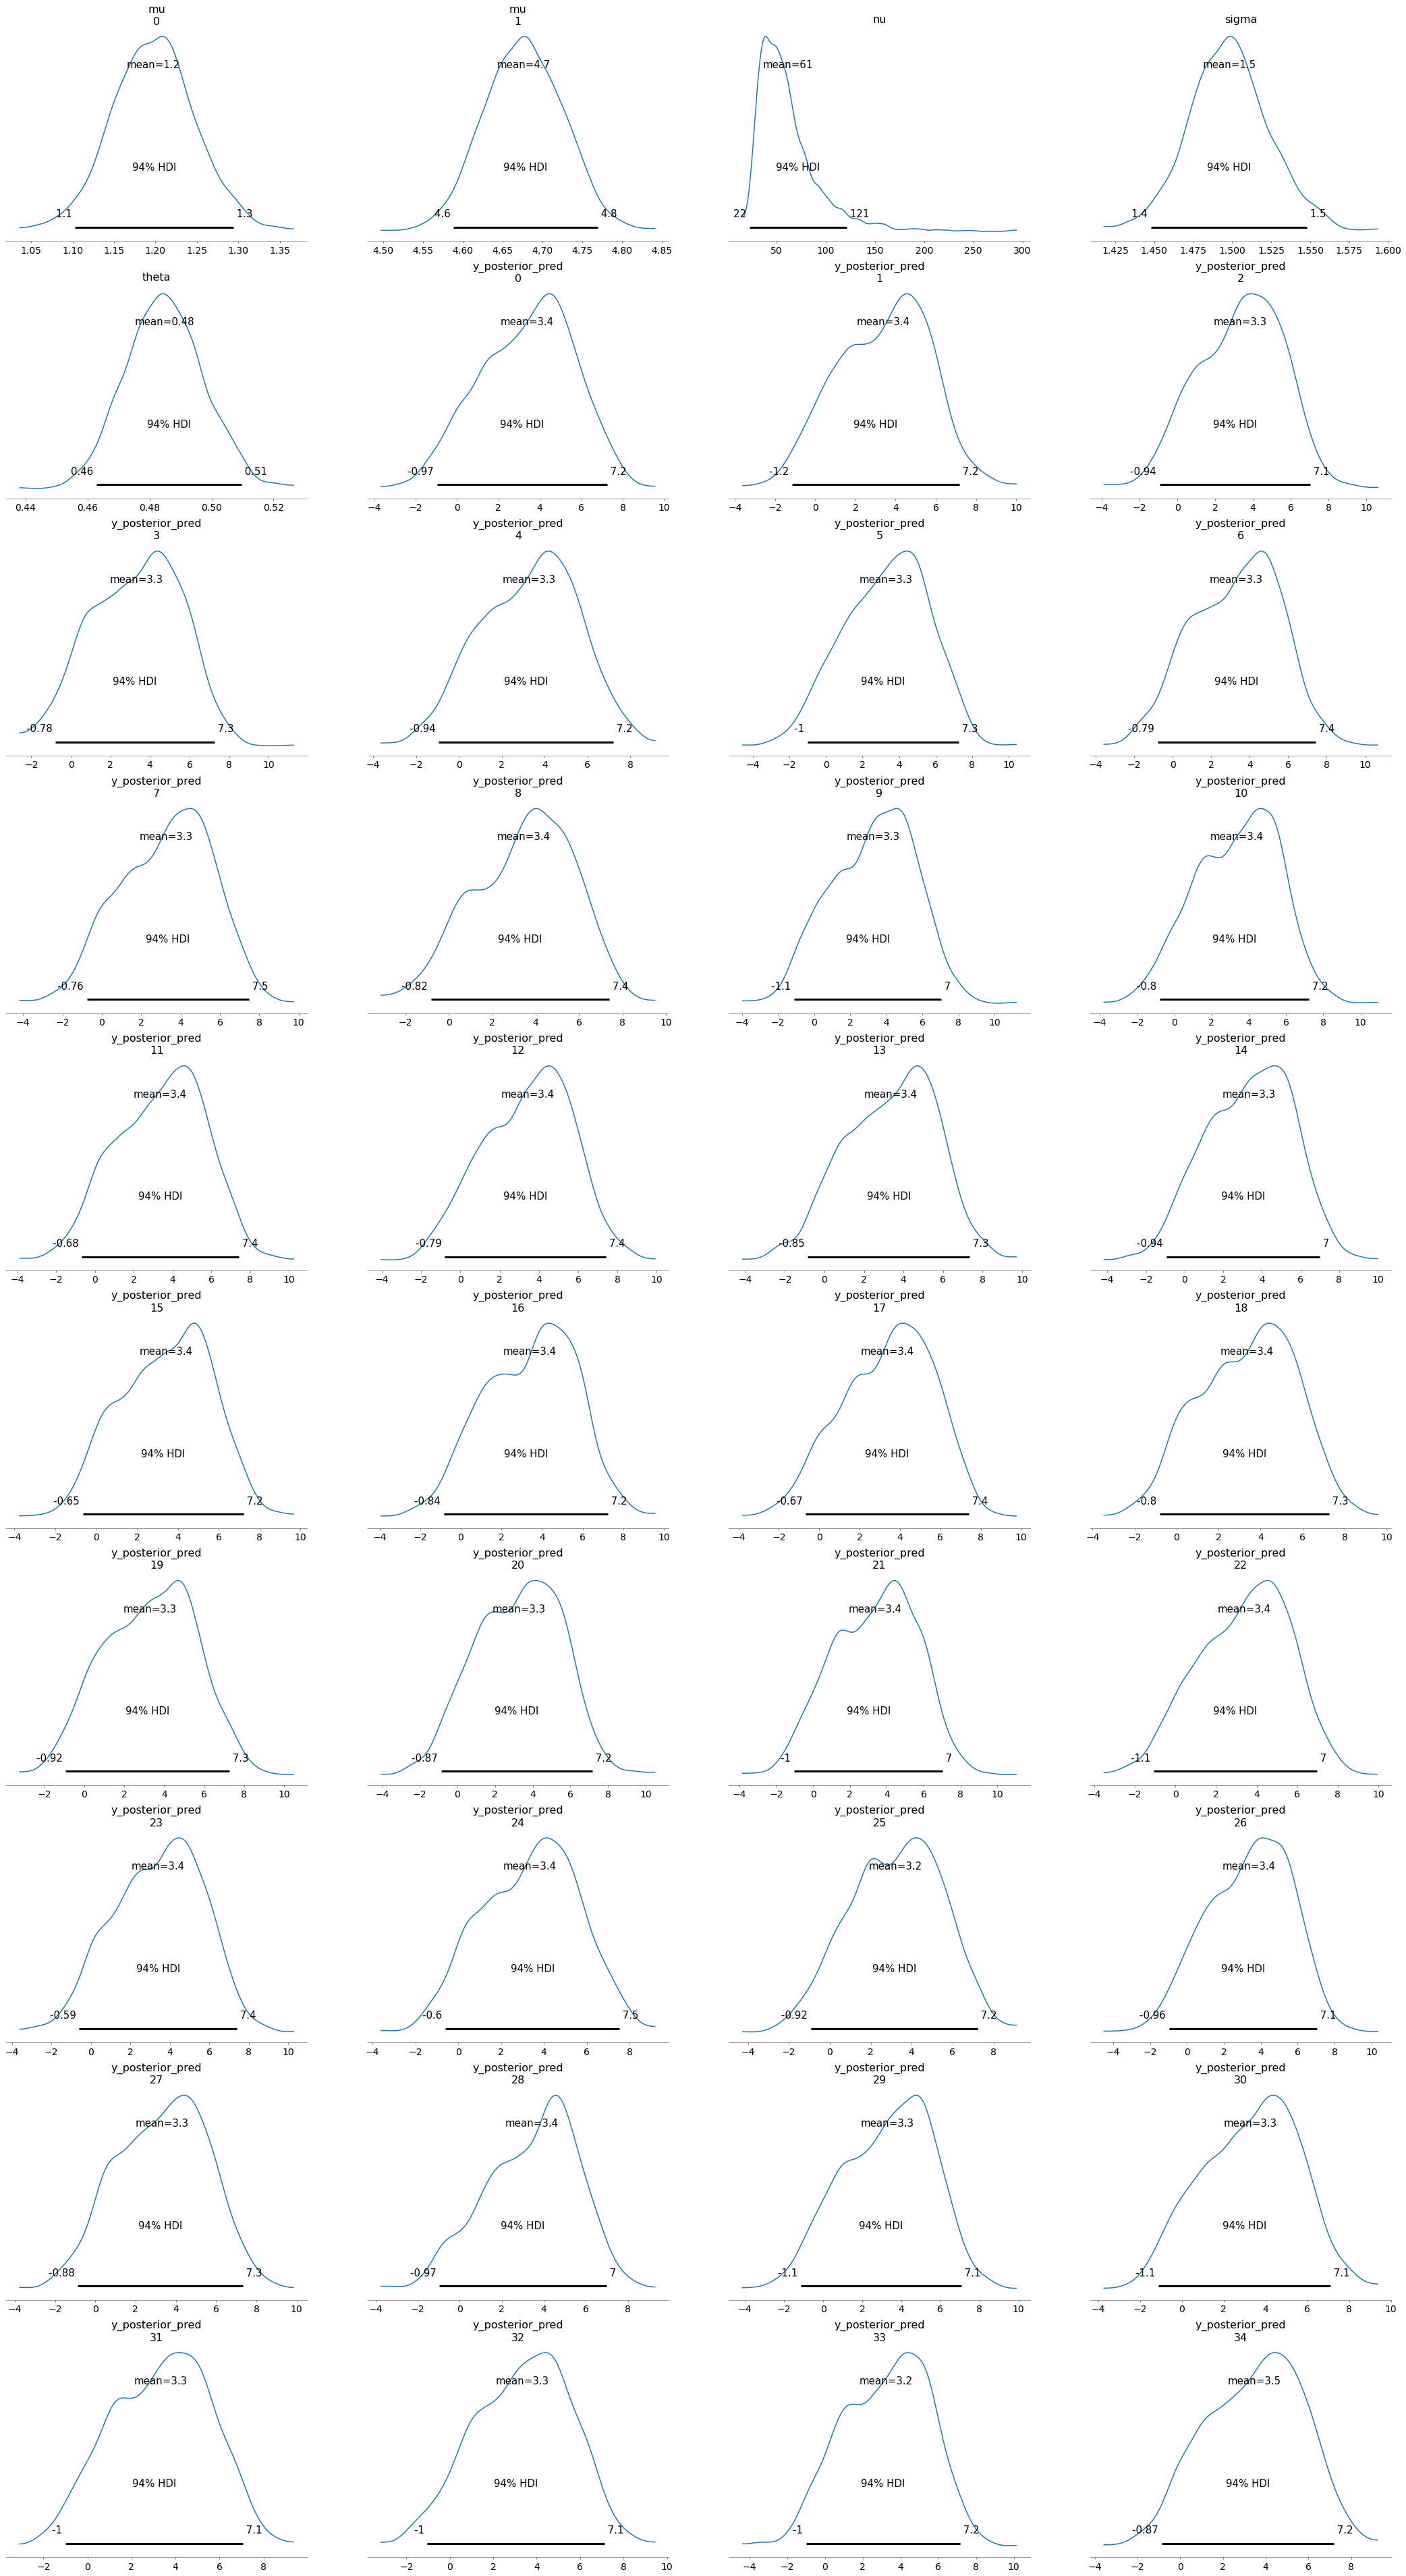

In [19]:
# Plot misspecified model posterior.
misspecified_model_idata = az.from_pystan(posterior = misspecified_model_fit, 
                                          posterior_model = misspecified_model_compiled)
az.plot_posterior(misspecified_model_idata)

### Posterior predictive check

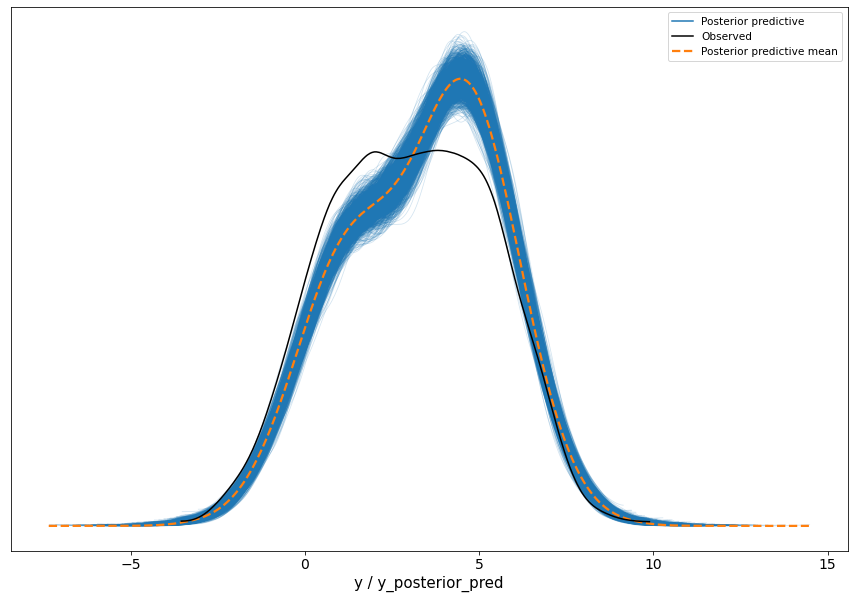

In [20]:
plt.rcParams["figure.figsize"] = (15, 10)
misspecified_model_ppc_data = az.from_pystan(posterior = misspecified_model_fit,
                                        posterior_model = misspecified_model_compiled,
                                        posterior_predictive = ["y_posterior_pred"], 
                                        observed_data = ["y"])
ax = az.plot_ppc(data = misspecified_model_ppc_data, 
                 data_pairs = {"y": "y_posterior_pred"})
plt.show()
plt.close()

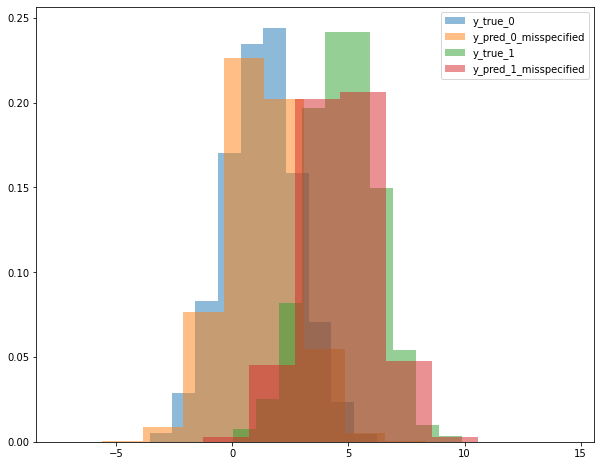

In [40]:
# Extract ground truth and predicted component memberships.
component_true = df["Component ID"].values
component_pred_misspecified = misspecified_model_idata.posterior.component_id_pred.values.flatten()

# Extract ground truth values for each mixture component.
y_true_0 = df[df["Component ID"] == 0]["Ground truth"].values
y_true_1 = df[df["Component ID"] == 1]["Ground truth"].values

# Extract predicted values for each mixture component.
y_pred_misspecified = misspecified_model_idata.posterior.y_posterior_pred.values
y_pred_misspecified = y_pred_misspecified.flatten()
y_pred_0_misspecified = y_pred_misspecified[~component_pred_misspecified.astype(bool)]
y_pred_1_misspecified = y_pred_misspecified[component_pred_misspecified.astype(bool)]

# Plot ground truth vs predictions for each mixture component.
plt.rcParams["figure.figsize"] = (10,8)
plt.hist(y_true_0, alpha = 0.5, label = "y_true_0", density = True)
plt.hist(y_pred_0_misspecified, alpha = 0.5, label = "y_pred_0_misspecified", density = True)
plt.hist(y_true_1, alpha = 0.5, label = "y_true_1", density = True)
plt.hist(y_pred_1_misspecified, alpha = 0.5, label = "y_pred_1_misspecified", density = True)
plt.legend(loc = "upper right")
plt.show()

In [38]:
np.unique(component_pred_misspecified, return_counts = True)

(array([0, 1]), array([3812526, 6187474]))

In [22]:
# Compare predicted component standard deviations to ground truth.
round_by = 3
sigma_pred_mean_misspecified = misspecified_model_idata.posterior.sigma.values.flatten().mean()
sigma_pred_sd_misspecified = misspecified_model_idata.posterior.sigma.values.flatten().std()
print("True standard deviation      :", *sigma)
print("Predicted standard deviation : {} (SD = {})".format(round(sigma_pred_mean_misspecified, round_by), 
                                                           round(sigma_pred_sd_misspecified, round_by)))

True standard deviation      : 1.5
Predicted standard deviation : 1.498 (SD = 0.026)


In [23]:
# Compare predicted component means to ground truth.
mu_0_pred_misspecified = [i[:,0] for i in misspecified_model_idata.posterior.mu.values]
mu_0_pred_misspecified = np.array(mu_0_pred_misspecified).flatten()
mu_1_pred_misspecified = [i[:,1] for i in misspecified_model_idata.posterior.mu.values]
mu_1_pred_misspecified = np.array(mu_1_pred_misspecified).flatten()

round_by = 3
print("-*- Component 0 -*-")
print("True mean      :", mu[0])
print("Predicted mean : {} (SD = {})".format(round(mu_0_pred_misspecified.mean(), round_by), 
                                             round(mu_0_pred_misspecified.std(), round_by)))
print("\n-*- Component 1 -*-")
print("True mean      :", mu[1])
print("Predicted mean : {} (SD = {})".format(round(mu_1_pred_misspecified.mean(), round_by), 
                                             round(mu_1_pred_misspecified.std(), round_by)))

-*- Component 0 -*-
True mean      : 1.25
Predicted mean : 1.198 (SD = 0.05)

-*- Component 1 -*-
True mean      : 4.75
Predicted mean : 4.677 (SD = 0.05)


## Compare correctly and incorrectly specified models

In [24]:
round_by = 3
print("-*- Component 0 -*-")
print("True mean                :", mu[0])
print("Correctly specified mean : {} (SD = {})".format(round(mu_0_pred_correct.mean(), round_by), 
                                                       round(mu_0_pred_correct.std(), round_by)))
print("Misspecified model mean  : {} (SD = {})".format(round(mu_0_pred_misspecified.mean(), round_by), 
                                                       round(mu_0_pred_misspecified.std(), round_by)))
print("\n-*- Component 1 -*-")
print("True mean                :", mu[1])
print("Correctly specified mean : {} (SD = {})".format(round(mu_1_pred_correct.mean(), round_by), 
                                                       round(mu_1_pred_correct.std(), round_by)))
print("Misspecified model mean  : {} (SD = {})".format(round(mu_1_pred_misspecified.mean(), round_by), 
                                                       round(mu_1_pred_misspecified.std(), round_by)))

-*- Component 0 -*-
True mean                : 1.25
Correctly specified mean : 4.677 (SD = 0.049)
Misspecified model mean  : 1.198 (SD = 0.05)

-*- Component 1 -*-
True mean                : 4.75
Correctly specified mean : 1.194 (SD = 0.053)
Misspecified model mean  : 4.677 (SD = 0.05)


## End of document